DWF Version: b'3.22.24'
DWF Version: b'3.22.24'
Opening first device
Starting oscilloscope
Starting acquisition 1718742001.5604858
Acquisition done
Acquisition 1718742001.5604858 completed
Plotting


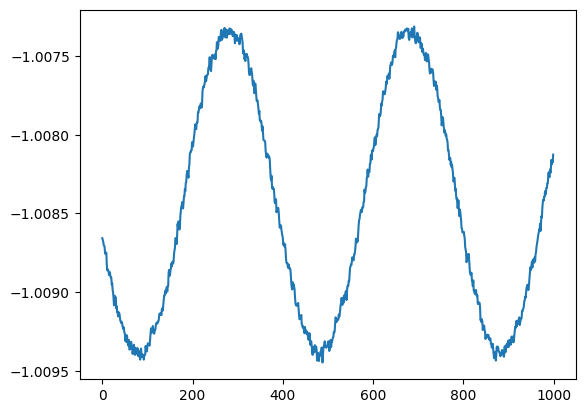

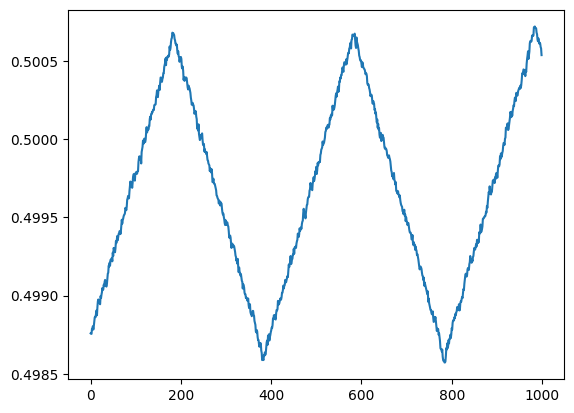

iteration finished
End time: 10.242910146713257
Starting acquisition 1718742011.803408


Process Process-5:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/root_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/root_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/luispelegrinagutierrez/Desktop/Doctorado/TPC_Commissioning/wvfm_scripts/Final_Code/save_functions.py", line 39, in save_multi
    with open(file_name, 'w', newline='') as csvfile:
FileNotFoundError: [Errno 2] No such file or directory: '/daq/scratch/FC_mini_osc/oscilloscope_data_1718742001-5604858_ALL.csv'


Saving data
Acquisition stopped by user


In [3]:
"""
   DWF Python Example
   Author:  Digilent, Inc.
   Revision:  2018-07-19

   Requires:                       
       Python 2.7, 3
"""
#load things
from ctypes import *
from dwfconstants import *
import math
import time
import matplotlib.pyplot as plt
import sys
import numpy as np
import csv
import os
import multiprocessing 
import save_functions as sf

if sys.platform.startswith("win"):
    dwf = cdll.dwf
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else:
    dwf = cdll.LoadLibrary("libdwf.so")

#declare ctype variables
hdwf = c_int()
sts = c_byte()


adq_frec = 100
hzAcq = c_double(adq_frec)
record_time = 10 #s

save_csv = True

nSamples = int(record_time * adq_frec)
rgdSamples_channel1 = (c_double*nSamples)()
rgdSamples_channel2 = (c_double*nSamples)()
rgdSamples_channel3 = (c_double*nSamples)()
rgdSamples_channel4 = (c_double*nSamples)()

if nSamples > 128000000.:
    print("Number of samples exceed oscilloscope buffer, lower the time, frequency or use Record function")
    quit()

version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("DWF Version: "+str(version.value))

dwf.FDwfParamSet(DwfParamOnClose, c_int(0)) # 0 = run, 1 = stop, 2 = shutdown

#print(DWF version
version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("DWF Version: "+str(version.value))


#open device
print("Opening first device")
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))


if hdwf.value == hdwfNone.value:
    szerr = create_string_buffer(512)
    dwf.FDwfGetLastErrorMsg(szerr)
    print(str(szerr.value))
    print("failed to open device")
    quit()

   
dwf.FDwfDeviceAutoConfigureSet(hdwf, c_int(0)) # 0 = the device will only be configured when FDwf###Configure is called

#set up acquisition
dwf.FDwfAnalogInFrequencySet(hdwf, hzAcq)
dwf.FDwfAnalogInBufferSizeSet(hdwf, c_int(nSamples))
dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(-1), c_int(1))
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(-1), c_double(5))
dwf.FDwfAnalogInChannelFilterSet(hdwf, c_int(-1), c_int(3))

#set up range channel by channel
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(0), c_double(0.2)) #1
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(1), c_double(0.2)) #2
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(2), c_double(0.4)) #3
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(3), c_double(0.4)) #4

#set up offset channel by channel
dwf.FDwfAnalogInChannelOffsetSet(hdwf, c_int(0), c_double(-1)) #1
dwf.FDwfAnalogInChannelOffsetSet(hdwf, c_int(1), c_double(0.5)) #2
dwf.FDwfAnalogInChannelOffsetSet(hdwf, c_int(2), c_double(0)) #3
dwf.FDwfAnalogInChannelOffsetSet(hdwf, c_int(3), c_double(0)) #4


#wait at least 2 seconds for the offset to stabilize
time.sleep(2)

print("Starting oscilloscope")
dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(1))

saving_directory = "/daq/scratch/FC_mini_osc/"

if __name__ == "__main__": 
    # creating multiprocessing Queue 
    q1 = multiprocessing.Queue(-1) 
    
    try:
        while True:
            start_time = time.time()

            print(f"Starting acquisition {start_time}")
            # Perform an acquisition and write the data to the CSV file

            # Record the end time
            csv_name = saving_directory + "oscilloscope_data_" + str(start_time).replace(".", "-" ) + "_ALL.csv"
            png_name = saving_directory + "oscilloscope_image_" + str(start_time).replace(".", "-" ) + "_ALL.png"
        
            # creating new processes 
            p1 = multiprocessing.Process(target=sf.save_multi, args=(csv_name, adq_frec, q1,)) 

            while True:
                dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
                if sts.value == DwfStateDone.value :
                    break
                time.sleep(0.01)
            print("Acquisition done")

            dwf.FDwfAnalogInStatusData(hdwf, 0, rgdSamples_channel1, nSamples) # get channel 1 data
            dwf.FDwfAnalogInStatusData(hdwf, 1, rgdSamples_channel2, nSamples) # get channel 2 data
            dwf.FDwfAnalogInStatusData(hdwf, 2, rgdSamples_channel3, nSamples) # get channel 3 data
            dwf.FDwfAnalogInStatusData(hdwf, 3, rgdSamples_channel4, nSamples) # get channel 4 data

            
            py_data = [list(rgdSamples_channel1), list(rgdSamples_channel2), list(rgdSamples_channel3), list(rgdSamples_channel4)]
            if save_csv:
                q1.put(py_data)
                p1.start()
            
            print(f"Acquisition {start_time} completed")


            
            print("Plotting")
            py_data = list(rgdSamples_channel1)
            plt.plot(np.fromiter(py_data, dtype = float))
            plt.show()
            
            py_data = list(rgdSamples_channel2)
            plt.plot(np.fromiter(py_data, dtype = float))
            plt.show()
            """
            py_data = list(rgdSamples_channel3)
            plt.plot(np.fromiter(py_data, dtype = float))
            plt.show()
            
            py_data = list(rgdSamples_channel4)
            plt.plot(np.fromiter(py_data, dtype = float))
            plt.show()
            """
            
            end_time = time.time()
            
            print("iteration finished")
        
            # Calculate the time difference
            end_time = time.time()
            print("End time:", end_time - start_time)
        
        
    except KeyboardInterrupt:
        print("Acquisition stopped by user")
        dwf.FDwfAnalogOutReset(hdwf, c_int(0))
        dwf.FDwfDeviceCloseAll()
        
